In [140]:
# 隨機從dataset中挑選N筆資料
from os import walk
from os.path import join
from os import stat
import random
import hashlib
import time

mypath = "D:\Download\chunkhash\enron"

# store all the fullpath of files in the root directory
file_names = []
# store 1000 fullpath to upload
upload_files = []
# store 200 fullpath to check dulplicate
check_files = []

# three lists simulate cloud server
dirty_chunk = []
cloud_chunk = []
cloud_hash = []

# check file data
check_chunk = []
check_hash = []

for root, dirs, files in walk(mypath):
    for f in files:
        fullpath = join(root, f)
        file_names.append(fullpath)

# os.stat(file).st_size return size of the file in bytes
for i in range(1000):
    random_int = random.randint(0, len(file_names) - 1)
    upload_files.append(file_names[random_int])
    
for i in range(200):
    random_int = random.randint(0, len(file_names) - 1)
    check_files.append(file_names[random_int])

In [141]:
def upload_file(upload_file_list, chunk_size):
    for file in upload_file_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()

        if(len(text) % chunk_size != 0):
            for i in range(chunk_size - (len(text) % chunk_size)):
                text += bytes.fromhex('30')
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
        cloud_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        cloud_hash.extend(text_hash)
        
def cut_check_file(check_file_list, chunk_size):
    for file in check_file_list:
        with open(file, 'rb') as f:
            text = f.read()
        f.close()
        
        if(len(text) % chunk_size != 0):
            for j in range(chunk_size - (len(text) % chunk_size)):
                text += bytes.fromhex('30')
        
        text_chunk = []
        for i in range(0, len(text), chunk_size):
            text_chunk.append(text[i: i + chunk_size])
            
        if(len(text_chunk) % 2 != 0):
            rand_chunk = text_chunk[random.randint(0, len(text_chunk) - 1)]
            text_chunk.append(rand_chunk)
        check_chunk.extend(text_chunk)
        
        text_hash = []
        for i in range(len(text_chunk)):
            hash_text = hashlib.sha256(text_chunk[i]).hexdigest()
            text_hash.append(hash_text)
        check_hash.extend(text_hash)

In [142]:
def set_dirty_chunk(dirty_percent):
    for i in range(int(len(cloud_hash) * dirty_percent)):
        dirty_chunk.append(cloud_hash[random.randint(0, len(cloud_hash) - 1)])

def zeus_check(chunk1, chunk2, hash_list):
    num = [0, []]
    for i in range(len(hash_list)):
        if(chunk1 == hash_list[i][0]):
            num[0] += 1
            if(hash_list[i][1] > 1):
                num[1].append(i)
                hash_list[i][1] -=1
        if(chunk2 == hash_list[i][0]):
            num[0] += 1
            if(hash_list[i][1] > 1):
                num[1].append(i)
                hash_list[i][1] -=1
    return num

def zeus(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    else:
        hash_list.append(chunk1)
    if(chunk2 in hash_list):
        num += 1
    else:
        hash_list.append(chunk2)
    
    if(num > 1):
        hash_list.append(chunk1)
    return num

def cal_commu_cost(chunk_size, is_zeus, has_dirty, thresh_max):
    upload_time = 0
    cost = 0
    cloud_copy = cloud_chunk.copy()
    hash_copy = cloud_hash.copy()
    
    start_time = time.time()
    
    if(thresh_max > 0):
        for i in range(len(hash_copy)):
            hash_copy[i] = [hash_copy[i], random.randint(1, thresh_max)]
   
    if(is_zeus and thresh_max > 0):
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_chunk) or (check_hash[i + 1] in dirty_chunk)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_chunk):
                        dirty_chunk.remove(check_hash[i])
                    if(check_hash[i + 1] in dirty_chunk):
                        dirty_chunk.remove(check_hash[i + 1])
                    val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
                    if(val[0] == 0):
                        hash_copy.append([check_hash[i], 0])
                        hash_copy.append([check_hash[i + 1], 0])
                    elif(val[0] == 1):
                        if(len(val[1]) > 0):
                            if(check_hash[i] == hash_copy[val[1][0]][0]):
                                hash_copy.append([check_hash[i + 1], 0])
                            else:
                                hash_copy.append([check_hash[i], 0])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
            val = zeus_check(check_hash[i], check_hash[i + 1], hash_copy)
            if(val[0] == 0):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                hash_copy.append([check_hash[i], 0])
                hash_copy.append([check_hash[i + 1], 0])
                cost += chunk_size * 2
                upload_time += 2
            elif(val[0] == 1):
                if(len(val[1]) > 0):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] == hash_copy[val[1][0]][0]):
                        hash_copy.append([check_hash[i + 1], 0])
                    else:
                        hash_copy.append([check_hash[i], 0])
                    cost += chunk_size * 2
                    upload_time += 2
                else:
                    xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                    if(len(xor_result) < (chunk_size * 2)):
                        for i in range((chunk_size * 2) - len(xor_result)):
                            xor_result = '0' + xor_result
                    cloud_copy.append(bytes.fromhex(xor_result))
                    cost += chunk_size
                    upload_time += 1
            else:
                if(len(val[1]) == 2):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                else:
                    xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                    if(len(xor_result) < (chunk_size * 2)):
                        for i in range((chunk_size * 2) - len(xor_result)):
                            xor_result = '0' + xor_result
                    cloud_copy.append(bytes.fromhex(xor_result))
                    cost += chunk_size
                    upload_time += 1
                    
    if(is_zeus and thresh_max == 0):
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_chunk) or (check_hash[i + 1] in dirty_chunk)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_chunk):
                        dirty_chunk.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_chunk):
                        dirty_chunk.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
            val = zeus(check_hash[i], check_hash[i + 1], hash_copy)        
            if(val == 0):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                hash_copy.append(check_hash[i])
                hash_copy.append(check_hash[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(not is_zeus):
        for i in range(len(check_hash)):
            cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_chunk):
                    cloud_copy.append(check_chunk[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    continue
            if(check_hash[i] not in hash_copy):
                cloud_copy.append(check_chunk[i])
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
                
    end_time = time.time()
    if(has_dirty):
        if(is_zeus):
            if(thresh_max > 0):
                print('dirty ZEUS having threshold %d, with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (thresh_max, chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
            else:
                print('dirty ZEUS with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(is_zeus):
        if(thresh_max > 0):
            print('ZEUS having threshold %d, with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (thresh_max, chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('ZEUS with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('origin dedup with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        
    return cost

In [143]:
def rare(chunk1, chunk2, hash_list):
    num = 0
    if(chunk1 in hash_list):
        num += 1
    if(chunk2 in hash_list):
        num += 1
    
    if(num == 0):
        hash_list.append(chunk1)
        hash_list.append(chunk2)
        return 2
    else:
        val = random.randint(1, 2)
        if(val == 1):
            if(chunk2 not in hash_list):
                hash_list.append(chunk2)
            if(chunk1 not in hash_list):
                hash_list.append(chunk1)
            return 1
        else:
            return 2

def rare_cost(chunk_size, do_dedup, do_rare, has_dirty):
    upload_time = 0
    cost = 0
    cloud_copy = cloud_chunk.copy()
    hash_copy = cloud_hash.copy()
    
    start_time = time.time()
    
    if(do_dedup and do_rare):        
        for i in range(0, len(check_hash), 2):
            cost += 64
            if(has_dirty):
                if((check_hash[i] in dirty_chunk) or (check_hash[i + 1] in dirty_chunk)):
                    cloud_copy.append(check_chunk[i])
                    cloud_copy.append(check_chunk[i + 1])
                    if(check_hash[i] in dirty_chunk):
                        dirty_chunk.remove(check_hash[i])
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    if(check_hash[i + 1] in dirty_chunk):
                        dirty_chunk.remove(check_hash[i + 1])
                    if(check_hash[i + 1] not in hash_copy):
                        hash_copy.append(check_hash[i + 1])
                    cost += chunk_size * 2
                    upload_time += 2
                    continue
            
            val = rare(check_hash[i], check_hash[i + 1], hash_copy)
            if(val == 2):
                cloud_copy.append(check_chunk[i])
                cloud_copy.append(check_chunk[i + 1])
                cost += chunk_size * 2
                upload_time += 2
            else:
                xor_result = hex(int(check_chunk[i].hex(), 16) ^ int(check_chunk[i + 1].hex(), 16))[2:]
                if(len(xor_result) < (chunk_size * 2)):
                    for i in range((chunk_size * 2) - len(xor_result)):
                        xor_result = '0' + xor_result
                cloud_copy.append(bytes.fromhex(xor_result))
                cost += chunk_size
                upload_time += 1
    if(do_dedup and (not do_rare)):
        for i in range(len(check_hash)):
            cost += 32
            if(has_dirty):
                if(check_hash[i] in dirty_chunk):
                    cloud_copy.append(check_chunk[i])
                    dirty_chunk.remove(check_hash[i])
                    cost += chunk_size
                    upload_time += 1
                    if(check_hash[i] not in hash_copy):
                        hash_copy.append(check_hash[i])
                    continue
                
            if(check_hash[i] not in hash_copy):
                cloud_copy.append(check_chunk[i])
                hash_copy.append(check_hash[i])
                cost += chunk_size
                upload_time += 1
    if(not do_dedup):
        cost = (32 + chunk_size) * len(check_hash)
        upload_time += len(check_hash)
    
    end_time = time.time()
    if(has_dirty):
        if(do_rare):
            print('dirty RARE with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
        else:
            print('dirty original dedup with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_rare):
        print('RARE with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    elif(do_dedup):
        print('origin dedup with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))
    else:
        print('no dedup with chunk size: %d bytes, run time: %f seconds, dedup percentage: %f %%' % (chunk_size, end_time - start_time, ((len(check_hash) - upload_time) / len(check_hash)) * 100))

    return cost

In [144]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs = []
zeus_costs = []
zeus5_costs = []
zeus20_costs = []
zeus40_costs = []

no_dedup_costs = []
origin_dedup_costs = []
rare_costs = []

# no dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
origin_costs.append(cal_commu_cost(128, False, False, 0))
zeus_costs.append(cal_commu_cost(128, True, False, 0))
zeus5_costs.append(cal_commu_cost(128, True, False, 5))
zeus20_costs.append(cal_commu_cost(128, True, False, 20))
zeus40_costs.append(cal_commu_cost(128, True, False, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, False))
rare_costs.append(rare_cost(128, True, True, False))

origin dedup with chunk size: 128 bytes, run time: 7.805964 seconds, dedup percentage: 3.117619 %
ZEUS with chunk size: 128 bytes, run time: 6.852743 seconds, dedup percentage: 2.881436 %
ZEUS having threshold 5, with chunk size: 128 bytes, run time: 22.157251 seconds, dedup percentage: 2.432688 %
ZEUS having threshold 20, with chunk size: 128 bytes, run time: 16.065573 seconds, dedup percentage: 2.361833 %
ZEUS having threshold 40, with chunk size: 128 bytes, run time: 19.680857 seconds, dedup percentage: 2.338214 %
no dedup with chunk size: 128 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
origin dedup with chunk size: 128 bytes, run time: 3.321810 seconds, dedup percentage: 3.117619 %
RARE with chunk size: 128 bytes, run time: 3.476025 seconds, dedup percentage: 1.464336 %


In [145]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

24001 24001
4234 4234
24 24
0.57% 0.57%


In [146]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660544]
[661824]
[664256]
[664640]
[664768]
-----------
[677440]
[660544]
[669504]


In [147]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
origin_costs.append(cal_commu_cost(256, False, False, 0))
zeus_costs.append(cal_commu_cost(256, True, False, 0))
zeus5_costs.append(cal_commu_cost(256, True, False, 5))
zeus20_costs.append(cal_commu_cost(256, True, False, 20))
zeus40_costs.append(cal_commu_cost(256, True, False, 40))

no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, False))
rare_costs.append(rare_cost(256, True, True, False))

origin dedup with chunk size: 256 bytes, run time: 0.888345 seconds, dedup percentage: 4.914337 %
ZEUS with chunk size: 256 bytes, run time: 1.021095 seconds, dedup percentage: 4.869252 %
ZEUS having threshold 5, with chunk size: 256 bytes, run time: 5.011661 seconds, dedup percentage: 3.787196 %
ZEUS having threshold 20, with chunk size: 256 bytes, run time: 7.364292 seconds, dedup percentage: 3.787196 %
ZEUS having threshold 40, with chunk size: 256 bytes, run time: 7.576891 seconds, dedup percentage: 3.877367 %
no dedup with chunk size: 256 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
origin dedup with chunk size: 256 bytes, run time: 1.403386 seconds, dedup percentage: 4.914337 %
RARE with chunk size: 256 bytes, run time: 1.354976 seconds, dedup percentage: 2.164112 %


In [148]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

12246 12246
2218 2218
9 9
0.41% 0.41%


In [149]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660544, 610880]
[661824, 611136]
[664256, 617280]
[664640, 617280]
[664768, 616768]
-----------
[677440, 638784]
[660544, 610880]
[669504, 626496]


In [150]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
origin_costs.append(cal_commu_cost(512, False, False, 0))
zeus_costs.append(cal_commu_cost(512, True, False, 0))
zeus5_costs.append(cal_commu_cost(512, True, False, 5))
zeus20_costs.append(cal_commu_cost(512, True, False, 20))
zeus40_costs.append(cal_commu_cost(512, True, False, 40))

no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, False))
rare_costs.append(rare_cost(512, True, True, False))

origin dedup with chunk size: 512 bytes, run time: 0.352841 seconds, dedup percentage: 6.418919 %
ZEUS with chunk size: 512 bytes, run time: 0.379788 seconds, dedup percentage: 6.418919 %
ZEUS having threshold 5, with chunk size: 512 bytes, run time: 1.636456 seconds, dedup percentage: 4.898649 %
ZEUS having threshold 20, with chunk size: 512 bytes, run time: 2.919065 seconds, dedup percentage: 4.983108 %
ZEUS having threshold 40, with chunk size: 512 bytes, run time: 2.125039 seconds, dedup percentage: 4.814189 %
no dedup with chunk size: 512 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
origin dedup with chunk size: 512 bytes, run time: 0.571434 seconds, dedup percentage: 6.418919 %
RARE with chunk size: 512 bytes, run time: 0.582920 seconds, dedup percentage: 2.195946 %


In [151]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

6388 6388
1184 1184
2 2
0.17% 0.17%


In [152]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660544, 610880, 605184]
[661824, 611136, 605184]
[664256, 617280, 614400]
[664640, 617280, 613888]
[664768, 616768, 614912]
-----------
[677440, 638784, 644096]
[660544, 610880, 605184]
[669504, 626496, 630784]


In [153]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
origin_costs.append(cal_commu_cost(1024, False, False, 0))
zeus_costs.append(cal_commu_cost(1024, True, False, 0))
zeus5_costs.append(cal_commu_cost(1024, True, False, 5))
zeus20_costs.append(cal_commu_cost(1024, True, False, 20))
zeus40_costs.append(cal_commu_cost(1024, True, False, 40))

no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, False))
rare_costs.append(rare_cost(1024, True, True, False))

origin dedup with chunk size: 1024 bytes, run time: 0.128263 seconds, dedup percentage: 15.669516 %
ZEUS with chunk size: 1024 bytes, run time: 0.215599 seconds, dedup percentage: 15.669516 %
ZEUS having threshold 5, with chunk size: 1024 bytes, run time: 0.768567 seconds, dedup percentage: 4.985755 %
ZEUS having threshold 20, with chunk size: 1024 bytes, run time: 0.634319 seconds, dedup percentage: 4.985755 %
ZEUS having threshold 40, with chunk size: 1024 bytes, run time: 0.755094 seconds, dedup percentage: 4.985755 %
no dedup with chunk size: 1024 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
origin dedup with chunk size: 1024 bytes, run time: 0.132250 seconds, dedup percentage: 15.669516 %
RARE with chunk size: 1024 bytes, run time: 0.109793 seconds, dedup percentage: 2.706553 %


In [154]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

3424 3424
702 702
0 0
0.00% 0.00%


In [155]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660544, 610880, 605184, 628672]
[661824, 611136, 605184, 628672]
[664256, 617280, 614400, 705472]
[664640, 617280, 613888, 705472]
[664768, 616768, 614912, 705472]
-----------
[677440, 638784, 644096, 741312]
[660544, 610880, 605184, 628672]
[669504, 626496, 630784, 721856]


In [156]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
origin_costs.append(cal_commu_cost(2048, False, False, 0))
zeus_costs.append(cal_commu_cost(2048, True, False, 0))
zeus5_costs.append(cal_commu_cost(2048, True, False, 5))
zeus20_costs.append(cal_commu_cost(2048, True, False, 20))
zeus40_costs.append(cal_commu_cost(2048, True, False, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, False))
rare_costs.append(rare_cost(2048, True, True, False))

origin dedup with chunk size: 2048 bytes, run time: 0.048409 seconds, dedup percentage: 29.233871 %
ZEUS with chunk size: 2048 bytes, run time: 0.389274 seconds, dedup percentage: 29.233871 %
ZEUS having threshold 5, with chunk size: 2048 bytes, run time: 0.285969 seconds, dedup percentage: 2.419355 %
ZEUS having threshold 20, with chunk size: 2048 bytes, run time: 0.286965 seconds, dedup percentage: 2.419355 %
ZEUS having threshold 40, with chunk size: 2048 bytes, run time: 0.233065 seconds, dedup percentage: 2.419355 %
no dedup with chunk size: 2048 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
origin dedup with chunk size: 2048 bytes, run time: 0.035434 seconds, dedup percentage: 29.233871 %
RARE with chunk size: 2048 bytes, run time: 0.062882 seconds, dedup percentage: 1.209677 %


In [157]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

1983 1983
496 496
0 0
0.00% 0.00%


In [158]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660544, 610880, 605184, 628672, 734720]
[661824, 611136, 605184, 628672, 734720]
[664256, 617280, 614400, 705472, 1007104]
[664640, 617280, 613888, 705472, 1007104]
[664768, 616768, 614912, 705472, 1007104]
-----------
[677440, 638784, 644096, 741312, 1031680]
[660544, 610880, 605184, 628672, 734720]
[669504, 626496, 630784, 721856, 1019392]


In [159]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# no dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
origin_costs.append(cal_commu_cost(4096, False, False, 0))
zeus_costs.append(cal_commu_cost(4096, True, False, 0))
zeus5_costs.append(cal_commu_cost(4096, True, False, 5))
zeus20_costs.append(cal_commu_cost(4096, True, False, 20))
zeus40_costs.append(cal_commu_cost(4096, True, False, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, False))
rare_costs.append(rare_cost(4096, True, True, False))

origin dedup with chunk size: 4096 bytes, run time: 0.019962 seconds, dedup percentage: 41.509434 %
ZEUS with chunk size: 4096 bytes, run time: 0.630825 seconds, dedup percentage: 41.509434 %
ZEUS having threshold 5, with chunk size: 4096 bytes, run time: 0.081848 seconds, dedup percentage: 0.943396 %
ZEUS having threshold 20, with chunk size: 4096 bytes, run time: 0.110293 seconds, dedup percentage: 0.943396 %
ZEUS having threshold 40, with chunk size: 4096 bytes, run time: 0.091322 seconds, dedup percentage: 0.943396 %
no dedup with chunk size: 4096 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
origin dedup with chunk size: 4096 bytes, run time: 0.015471 seconds, dedup percentage: 41.509434 %
RARE with chunk size: 4096 bytes, run time: 0.019463 seconds, dedup percentage: 0.471698 %


In [160]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

1362 1362
424 424
0 0
0.00% 0.00%


In [161]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660544, 610880, 605184, 628672, 734720, 1029376]
[661824, 611136, 605184, 628672, 734720, 1029376]
[664256, 617280, 614400, 705472, 1007104, 1733888]
[664640, 617280, 613888, 705472, 1007104, 1733888]
[664768, 616768, 614912, 705472, 1007104, 1733888]
-----------
[677440, 638784, 644096, 741312, 1031680, 1750272]
[660544, 610880, 605184, 628672, 734720, 1029376]
[669504, 626496, 630784, 721856, 1019392, 1742080]


Origin Data Dedup: [660544, 610880, 605184, 628672, 734720, 1029376]
ZEUS:              [661824, 611136, 605184, 628672, 734720, 1029376]
ZEUS+(B=5):        [664256, 617280, 614400, 705472, 1007104, 1733888]
ZEUS+(B=20):       [664640, 617280, 613888, 705472, 1007104, 1733888]
ZEUS+(B=40):       [664768, 616768, 614912, 705472, 1007104, 1733888]
-------------
Without Data Dedup: [677440, 638784, 644096, 741312, 1031680, 1750272]
Rare:               [669504, 626496, 630784, 721856, 1019392, 1742080]
Origin Data Dedup:  [660544, 610880, 605184, 628672, 734720, 1029376]


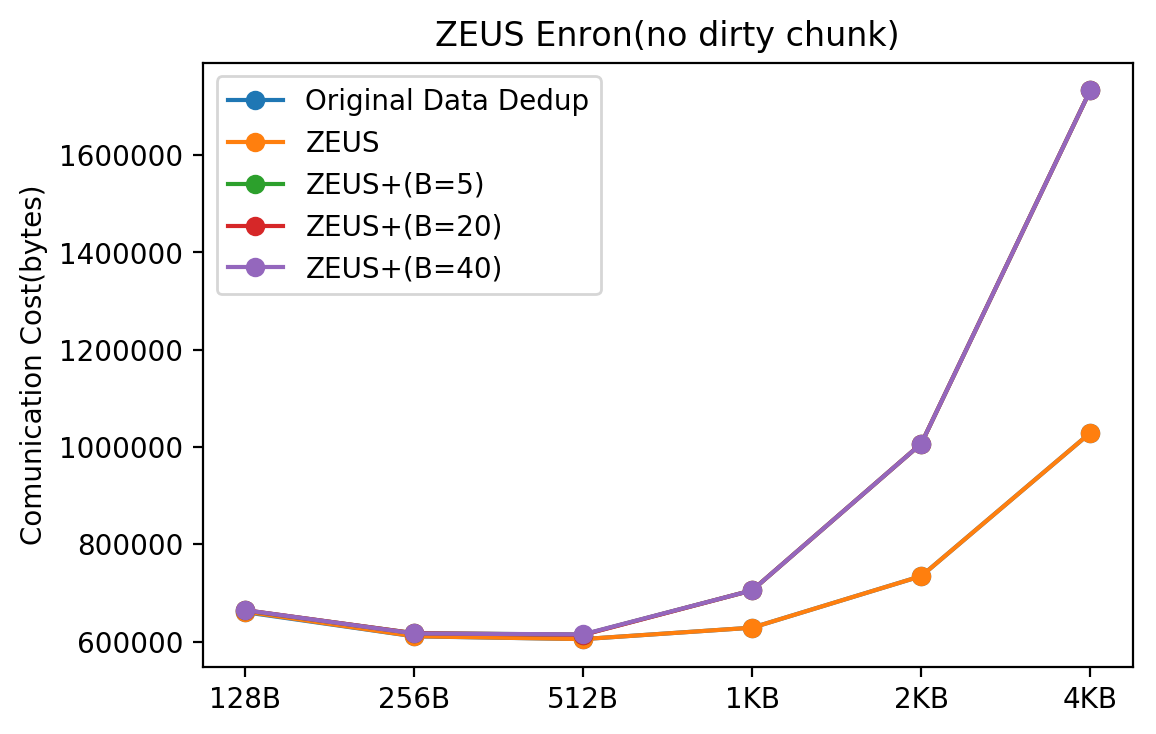

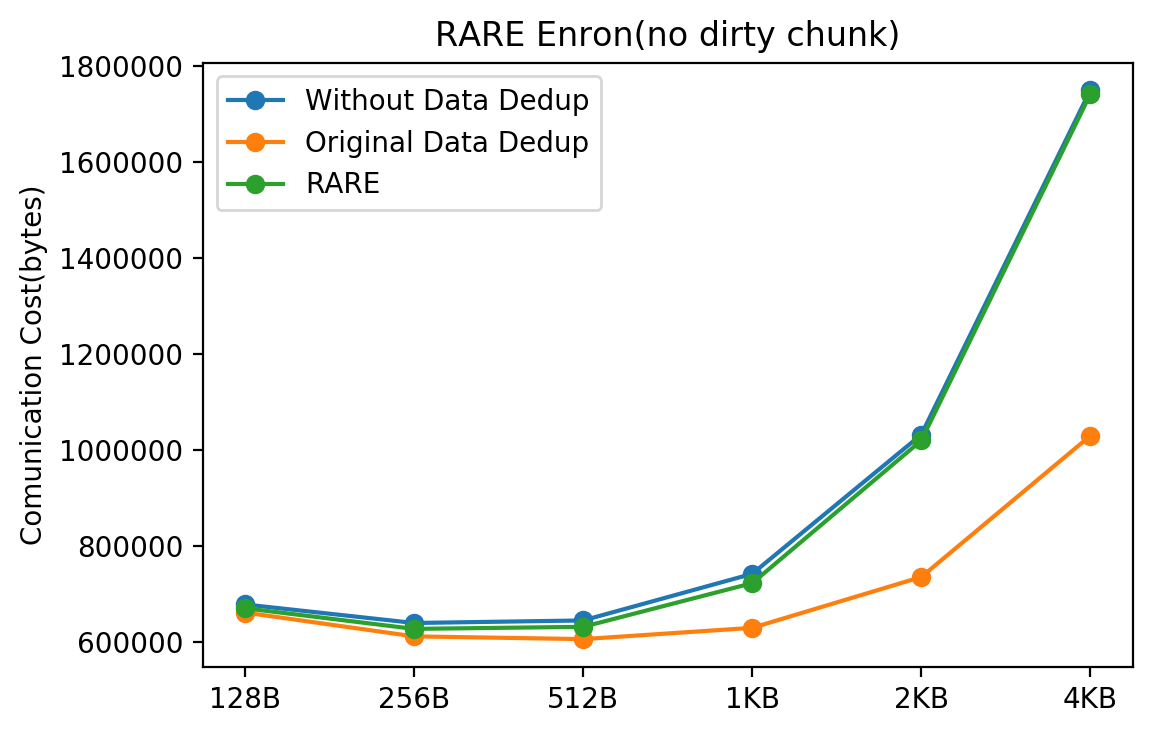

In [162]:
no_dirty = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
no_dirty_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)


%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(dpi = 200)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(no dirty chunk)')
plt.show()

plt.figure(dpi = 200)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(no dirty chunk)')
plt.show()

In [163]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 10% dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))

no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, run time: 5.227269 seconds, dedup percentage: 3.094001 %
dirty ZEUS with chunk size: 128 bytes, run time: 7.437153 seconds, dedup percentage: 2.857818 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, run time: 22.687264 seconds, dedup percentage: 2.503543 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, run time: 16.013190 seconds, dedup percentage: 2.385451 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, run time: 16.900050 seconds, dedup percentage: 2.385451 %
no dedup with chunk size: 128 bytes, run time: 0.000499 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, run time: 3.438599 seconds, dedup percentage: 3.117619 %
dirty RARE with chunk size: 128 bytes, run time: 3.578837 seconds, dedup percentage: 1.464336 %


In [164]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

24001 24001
4234 4234
24 24
0.57% 0.57%


In [165]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660672]
[661952]
[663872]
[664512]
[664512]
-----------
[677440]
[660544]
[669504]


In [166]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, run time: 2.446947 seconds, dedup percentage: 4.824166 %
dirty ZEUS with chunk size: 256 bytes, run time: 2.511824 seconds, dedup percentage: 4.779080 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, run time: 8.118381 seconds, dedup percentage: 3.877367 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, run time: 7.530979 seconds, dedup percentage: 3.742110 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, run time: 7.748571 seconds, dedup percentage: 3.697024 %
no dedup with chunk size: 256 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, run time: 2.011753 seconds, dedup percentage: 4.914337 %
dirty RARE with chunk size: 256 bytes, run time: 1.777689 seconds, dedup percentage: 2.209197 %


In [167]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

12246 12246
2218 2218
9 9
0.41% 0.41%


In [168]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660672, 611392]
[661952, 611648]
[663872, 616768]
[664512, 617536]
[664512, 617792]
-----------
[677440, 638784]
[660544, 610880]
[669504, 626240]


In [169]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, run time: 0.471121 seconds, dedup percentage: 6.418919 %
dirty ZEUS with chunk size: 512 bytes, run time: 0.440678 seconds, dedup percentage: 6.418919 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, run time: 1.844062 seconds, dedup percentage: 4.729730 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, run time: 1.890979 seconds, dedup percentage: 4.645270 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, run time: 2.156981 seconds, dedup percentage: 4.645270 %
no dedup with chunk size: 512 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, run time: 0.393269 seconds, dedup percentage: 6.418919 %
dirty RARE with chunk size: 512 bytes, run time: 0.444673 seconds, dedup percentage: 2.871622 %


In [170]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

6388 6388
1184 1184
1 1
0.08% 0.08%


In [171]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660672, 611392, 605184]
[661952, 611648, 605184]
[663872, 616768, 615424]
[664512, 617536, 615936]
[664512, 617792, 615936]
-----------
[677440, 638784, 644096]
[660544, 610880, 605184]
[669504, 626240, 626688]


In [172]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, run time: 0.151219 seconds, dedup percentage: 15.669516 %
dirty ZEUS with chunk size: 1024 bytes, run time: 0.213105 seconds, dedup percentage: 15.669516 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, run time: 0.666762 seconds, dedup percentage: 5.128205 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, run time: 0.736629 seconds, dedup percentage: 5.128205 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, run time: 0.608864 seconds, dedup percentage: 5.128205 %
no dedup with chunk size: 1024 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, run time: 0.109796 seconds, dedup percentage: 15.669516 %
dirty RARE with chunk size: 1024 bytes, run time: 0.173181 seconds, dedup percentage: 2.136752 %


In [173]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

3424 3424
702 702
0 0
0.00% 0.00%


In [174]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660672, 611392, 605184, 628672]
[661952, 611648, 605184, 628672]
[663872, 616768, 615424, 704448]
[664512, 617536, 615936, 704448]
[664512, 617792, 615936, 704448]
-----------
[677440, 638784, 644096, 741312]
[660544, 610880, 605184, 628672]
[669504, 626240, 626688, 725952]


In [175]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))

no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, run time: 0.069868 seconds, dedup percentage: 29.233871 %
dirty ZEUS with chunk size: 2048 bytes, run time: 0.446172 seconds, dedup percentage: 29.233871 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, run time: 0.312918 seconds, dedup percentage: 3.024194 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, run time: 0.305926 seconds, dedup percentage: 3.024194 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, run time: 0.216098 seconds, dedup percentage: 3.024194 %
no dedup with chunk size: 2048 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, run time: 0.036930 seconds, dedup percentage: 29.233871 %
dirty RARE with chunk size: 2048 bytes, run time: 0.049407 seconds, dedup percentage: 1.209677 %


In [176]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

1983 1983
496 496
0 0
0.00% 0.00%


In [177]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660672, 611392, 605184, 628672, 734720]
[661952, 611648, 605184, 628672, 734720]
[663872, 616768, 615424, 704448, 1000960]
[664512, 617536, 615936, 704448, 1000960]
[664512, 617792, 615936, 704448, 1000960]
-----------
[677440, 638784, 644096, 741312, 1031680]
[660544, 610880, 605184, 628672, 734720]
[669504, 626240, 626688, 725952, 1019392]


In [178]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 10% dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
set_dirty_chunk(0.1)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))

no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, run time: 0.020462 seconds, dedup percentage: 41.509434 %
dirty ZEUS with chunk size: 4096 bytes, run time: 0.958214 seconds, dedup percentage: 41.509434 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, run time: 0.119277 seconds, dedup percentage: 0.943396 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, run time: 0.126264 seconds, dedup percentage: 0.943396 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, run time: 0.135748 seconds, dedup percentage: 0.943396 %
no dedup with chunk size: 4096 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, run time: 0.026952 seconds, dedup percentage: 41.509434 %
dirty RARE with chunk size: 4096 bytes, run time: 0.022456 seconds, dedup percentage: 0.471698 %


In [179]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

1362 1362
424 424
0 0
0.00% 0.00%


In [180]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[660672, 611392, 605184, 628672, 734720, 1029376]
[661952, 611648, 605184, 628672, 734720, 1029376]
[663872, 616768, 615424, 704448, 1000960, 1733888]
[664512, 617536, 615936, 704448, 1000960, 1733888]
[664512, 617792, 615936, 704448, 1000960, 1733888]
-----------
[677440, 638784, 644096, 741312, 1031680, 1750272]
[660544, 610880, 605184, 628672, 734720, 1029376]
[669504, 626240, 626688, 725952, 1019392, 1742080]


Origin Data Dedup: [660672, 611392, 605184, 628672, 734720, 1029376]
ZEUS:              [661952, 611648, 605184, 628672, 734720, 1029376]
ZEUS+(B=5):        [663872, 616768, 615424, 704448, 1000960, 1733888]
ZEUS+(B=20):       [664512, 617536, 615936, 704448, 1000960, 1733888]
ZEUS+(B=40):       [664512, 617792, 615936, 704448, 1000960, 1733888]
-------------
Without Data Dedup: [677440, 638784, 644096, 741312, 1031680, 1750272]
Rare:               [669504, 626240, 626688, 725952, 1019392, 1742080]
Origin Data Dedup:  [660544, 610880, 605184, 628672, 734720, 1029376]


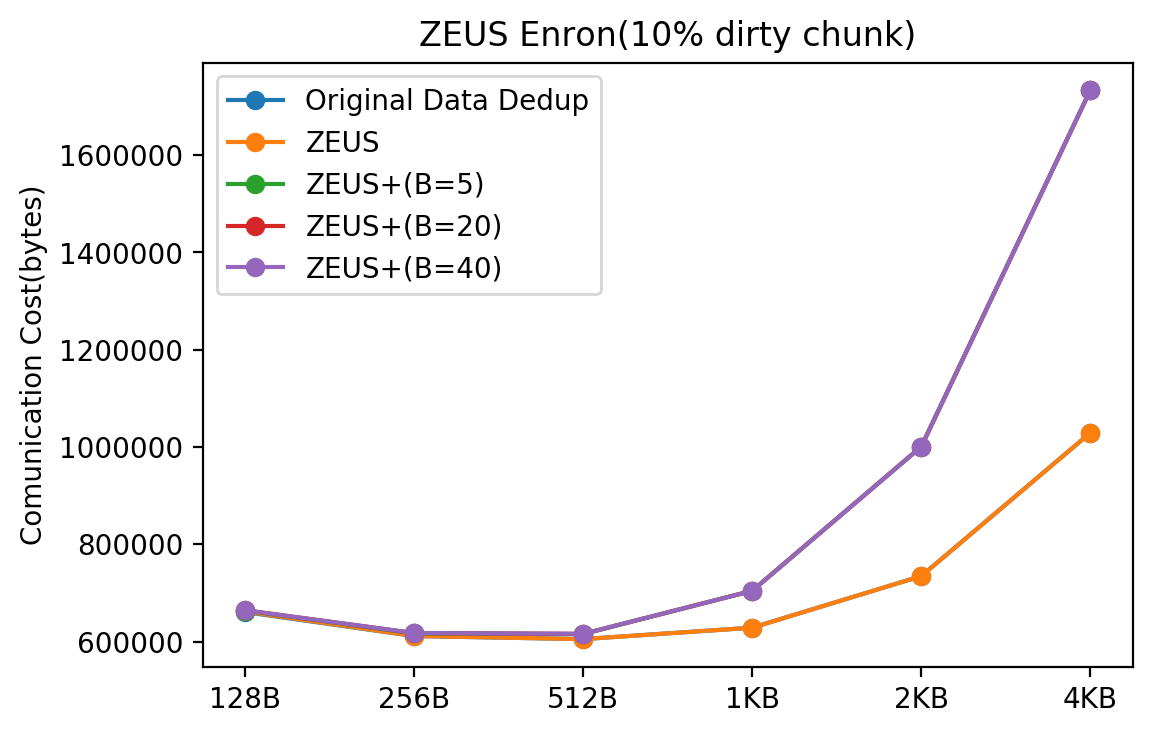

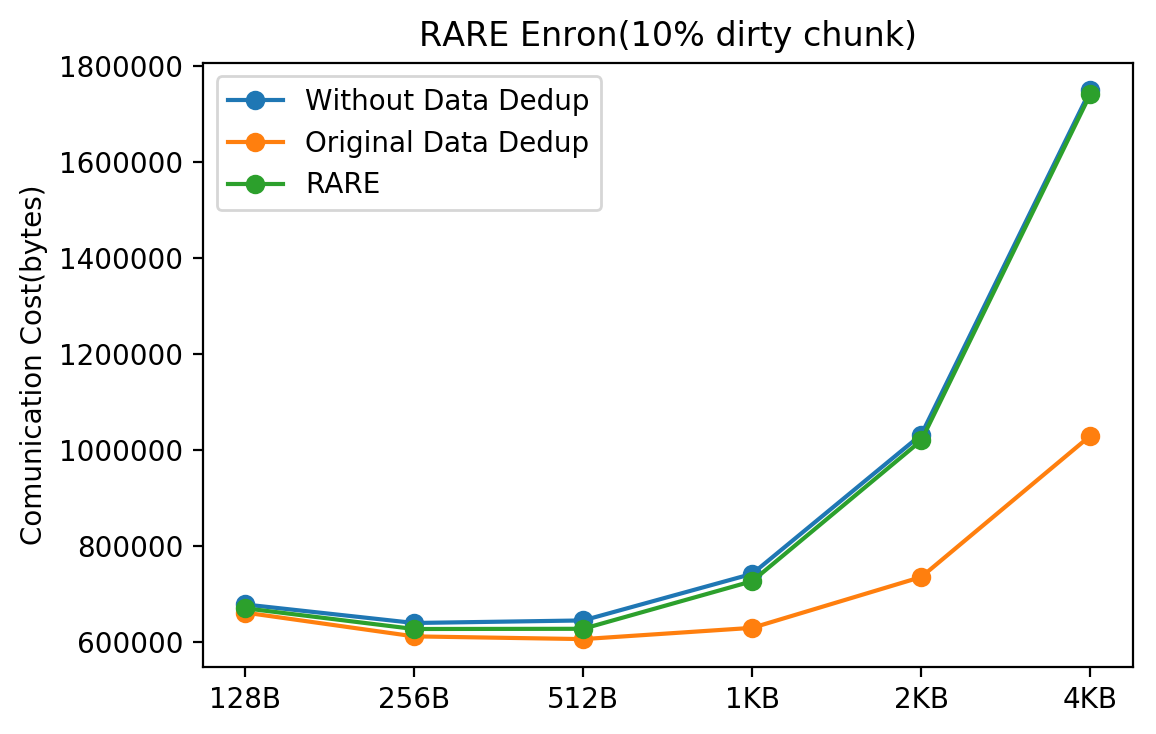

In [181]:
dirty10 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty10_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 200)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 200)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(10% dirty chunk)')
plt.show()

In [182]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

origin_costs.clear()
zeus_costs.clear()
zeus5_costs.clear()
zeus20_costs.clear()
zeus40_costs.clear()

no_dedup_costs.clear()
origin_dedup_costs.clear()
rare_costs.clear()

# 25% dirty chunk 128B
upload_file(upload_files, 128)
cut_check_file(check_files, 128)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(128, False, True, 0))
zeus_costs.append(cal_commu_cost(128, True, True, 0))
zeus5_costs.append(cal_commu_cost(128, True, True, 5))
zeus20_costs.append(cal_commu_cost(128, True, True, 20))
zeus40_costs.append(cal_commu_cost(128, True, True, 40))
no_dedup_costs.append(rare_cost(128, False, False, False))
origin_dedup_costs.append(rare_cost(128, True, False, True))
rare_costs.append(rare_cost(128, True, True, True))

dirty original dedup with chunk size: 128 bytes, run time: 8.238661 seconds, dedup percentage: 2.905054 %
dirty ZEUS with chunk size: 128 bytes, run time: 10.205000 seconds, dedup percentage: 2.716108 %
dirty ZEUS having threshold 5, with chunk size: 128 bytes, run time: 30.064525 seconds, dedup percentage: 2.479924 %
dirty ZEUS having threshold 20, with chunk size: 128 bytes, run time: 28.458019 seconds, dedup percentage: 2.361833 %
dirty ZEUS having threshold 40, with chunk size: 128 bytes, run time: 23.782221 seconds, dedup percentage: 2.338214 %
no dedup with chunk size: 128 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 128 bytes, run time: 5.955408 seconds, dedup percentage: 3.117619 %
dirty RARE with chunk size: 128 bytes, run time: 10.934643 seconds, dedup percentage: 1.464336 %


In [183]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

24001 24001
4234 4234
25 25
0.59% 0.59%


In [184]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[661696]
[662720]
[664000]
[664640]
[664768]
-----------
[677440]
[660544]
[669504]


In [185]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 256B
upload_file(upload_files, 256)
cut_check_file(check_files, 256)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(256, False, True, 0))
zeus_costs.append(cal_commu_cost(256, True, True, 0))
zeus5_costs.append(cal_commu_cost(256, True, True, 5))
zeus20_costs.append(cal_commu_cost(256, True, True, 20))
zeus40_costs.append(cal_commu_cost(256, True, True, 40))
no_dedup_costs.append(rare_cost(256, False, False, False))
origin_dedup_costs.append(rare_cost(256, True, False, True))
rare_costs.append(rare_cost(256, True, True, True))

dirty original dedup with chunk size: 256 bytes, run time: 4.279533 seconds, dedup percentage: 4.824166 %
dirty ZEUS with chunk size: 256 bytes, run time: 4.193190 seconds, dedup percentage: 4.779080 %
dirty ZEUS having threshold 5, with chunk size: 256 bytes, run time: 10.278363 seconds, dedup percentage: 3.877367 %
dirty ZEUS having threshold 20, with chunk size: 256 bytes, run time: 5.421406 seconds, dedup percentage: 3.742110 %
dirty ZEUS having threshold 40, with chunk size: 256 bytes, run time: 5.589095 seconds, dedup percentage: 3.742110 %
no dedup with chunk size: 256 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 256 bytes, run time: 1.219726 seconds, dedup percentage: 4.914337 %
dirty RARE with chunk size: 256 bytes, run time: 1.338008 seconds, dedup percentage: 1.938683 %


In [186]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

12246 12246
2218 2218
8 8
0.36% 0.36%


In [187]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[661696, 611392]
[662720, 611648]
[664000, 616768]
[664640, 617536]
[664768, 617536]
-----------
[677440, 638784]
[660544, 610880]
[669504, 627776]


In [188]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 512B
upload_file(upload_files, 512)
cut_check_file(check_files, 512)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(512, False, True, 0))
zeus_costs.append(cal_commu_cost(512, True, True, 0))
zeus5_costs.append(cal_commu_cost(512, True, True, 5))
zeus20_costs.append(cal_commu_cost(512, True, True, 20))
zeus40_costs.append(cal_commu_cost(512, True, True, 40))
no_dedup_costs.append(rare_cost(512, False, False, False))
origin_dedup_costs.append(rare_cost(512, True, False, True))
rare_costs.append(rare_cost(512, True, True, True))

dirty original dedup with chunk size: 512 bytes, run time: 0.341862 seconds, dedup percentage: 6.418919 %
dirty ZEUS with chunk size: 512 bytes, run time: 0.356338 seconds, dedup percentage: 6.418919 %
dirty ZEUS having threshold 5, with chunk size: 512 bytes, run time: 1.587044 seconds, dedup percentage: 4.898649 %
dirty ZEUS having threshold 20, with chunk size: 512 bytes, run time: 1.501204 seconds, dedup percentage: 4.898649 %
dirty ZEUS having threshold 40, with chunk size: 512 bytes, run time: 1.537138 seconds, dedup percentage: 4.898649 %
no dedup with chunk size: 512 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 512 bytes, run time: 0.366816 seconds, dedup percentage: 6.418919 %
dirty RARE with chunk size: 512 bytes, run time: 0.317409 seconds, dedup percentage: 2.027027 %


In [189]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

6388 6388
1184 1184
1 1
0.08% 0.08%


In [190]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[661696, 611392, 605184]
[662720, 611648, 605184]
[664000, 616768, 614400]
[664640, 617536, 614400]
[664768, 617536, 614400]
-----------
[677440, 638784, 644096]
[660544, 610880, 605184]
[669504, 627776, 631808]


In [191]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 1KB
upload_file(upload_files, 1024)
cut_check_file(check_files, 1024)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(1024, False, True, 0))
zeus_costs.append(cal_commu_cost(1024, True, True, 0))
zeus5_costs.append(cal_commu_cost(1024, True, True, 5))
zeus20_costs.append(cal_commu_cost(1024, True, True, 20))
zeus40_costs.append(cal_commu_cost(1024, True, True, 40))
no_dedup_costs.append(rare_cost(1024, False, False, False))
origin_dedup_costs.append(rare_cost(1024, True, False, True))
rare_costs.append(rare_cost(1024, True, True, True))

dirty original dedup with chunk size: 1024 bytes, run time: 0.081348 seconds, dedup percentage: 15.669516 %
dirty ZEUS with chunk size: 1024 bytes, run time: 0.145728 seconds, dedup percentage: 15.669516 %
dirty ZEUS having threshold 5, with chunk size: 1024 bytes, run time: 0.613357 seconds, dedup percentage: 4.985755 %
dirty ZEUS having threshold 20, with chunk size: 1024 bytes, run time: 0.610364 seconds, dedup percentage: 4.985755 %
dirty ZEUS having threshold 40, with chunk size: 1024 bytes, run time: 0.926274 seconds, dedup percentage: 4.985755 %
no dedup with chunk size: 1024 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 1024 bytes, run time: 0.111292 seconds, dedup percentage: 15.669516 %
dirty RARE with chunk size: 1024 bytes, run time: 0.233566 seconds, dedup percentage: 2.564103 %


In [192]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

3424 3424
702 702
0 0
0.00% 0.00%


In [193]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[661696, 611392, 605184, 628672]
[662720, 611648, 605184, 628672]
[664000, 616768, 614400, 705472]
[664640, 617536, 614400, 705472]
[664768, 617536, 614400, 705472]
-----------
[677440, 638784, 644096, 741312]
[660544, 610880, 605184, 628672]
[669504, 627776, 631808, 722880]


In [194]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 2KB
upload_file(upload_files, 2048)
cut_check_file(check_files, 2048)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(2048, False, True, 0))
zeus_costs.append(cal_commu_cost(2048, True, True, 0))
zeus5_costs.append(cal_commu_cost(2048, True, True, 5))
zeus20_costs.append(cal_commu_cost(2048, True, True, 20))
zeus40_costs.append(cal_commu_cost(2048, True, True, 40))
no_dedup_costs.append(rare_cost(2048, False, False, False))
origin_dedup_costs.append(rare_cost(2048, True, False, True))
rare_costs.append(rare_cost(2048, True, True, True))

dirty original dedup with chunk size: 2048 bytes, run time: 0.027949 seconds, dedup percentage: 29.233871 %
dirty ZEUS with chunk size: 2048 bytes, run time: 0.291459 seconds, dedup percentage: 29.233871 %
dirty ZEUS having threshold 5, with chunk size: 2048 bytes, run time: 0.186650 seconds, dedup percentage: 2.822581 %
dirty ZEUS having threshold 20, with chunk size: 2048 bytes, run time: 0.164693 seconds, dedup percentage: 2.822581 %
dirty ZEUS having threshold 40, with chunk size: 2048 bytes, run time: 0.175673 seconds, dedup percentage: 2.822581 %
no dedup with chunk size: 2048 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 2048 bytes, run time: 0.037431 seconds, dedup percentage: 29.233871 %
dirty RARE with chunk size: 2048 bytes, run time: 0.040919 seconds, dedup percentage: 1.411290 %


In [195]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

1983 1983
496 496
0 0
0.00% 0.00%


In [196]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[661696, 611392, 605184, 628672, 734720]
[662720, 611648, 605184, 628672, 734720]
[664000, 616768, 614400, 705472, 1003008]
[664640, 617536, 614400, 705472, 1003008]
[664768, 617536, 614400, 705472, 1003008]
-----------
[677440, 638784, 644096, 741312, 1031680]
[660544, 610880, 605184, 628672, 734720]
[669504, 627776, 631808, 722880, 1017344]


In [197]:
cloud_chunk.clear()
cloud_hash.clear()
dirty_chunk.clear()
check_chunk.clear()
check_hash.clear()

# 25% dirty chunk 4KB
upload_file(upload_files, 4096)
cut_check_file(check_files, 4096)
set_dirty_chunk(0.25)
origin_costs.append(cal_commu_cost(4096, False, True, 0))
zeus_costs.append(cal_commu_cost(4096, True, True, 0))
zeus5_costs.append(cal_commu_cost(4096, True, True, 5))
zeus20_costs.append(cal_commu_cost(4096, True, True, 20))
zeus40_costs.append(cal_commu_cost(4096, True, True, 40))
no_dedup_costs.append(rare_cost(4096, False, False, False))
origin_dedup_costs.append(rare_cost(4096, True, False, True))
rare_costs.append(rare_cost(4096, True, True, True))

dirty original dedup with chunk size: 4096 bytes, run time: 0.030942 seconds, dedup percentage: 41.509434 %
dirty ZEUS with chunk size: 4096 bytes, run time: 0.716166 seconds, dedup percentage: 41.509434 %
dirty ZEUS having threshold 5, with chunk size: 4096 bytes, run time: 0.112288 seconds, dedup percentage: 0.707547 %
dirty ZEUS having threshold 20, with chunk size: 4096 bytes, run time: 0.126264 seconds, dedup percentage: 0.707547 %
dirty ZEUS having threshold 40, with chunk size: 4096 bytes, run time: 0.112788 seconds, dedup percentage: 0.707547 %
no dedup with chunk size: 4096 bytes, run time: 0.000000 seconds, dedup percentage: 0.000000 %
dirty original dedup with chunk size: 4096 bytes, run time: 0.019960 seconds, dedup percentage: 41.509434 %
dirty RARE with chunk size: 4096 bytes, run time: 0.021459 seconds, dedup percentage: 0.235849 %


In [198]:
print(len(cloud_chunk), len(cloud_hash))
print(len(check_chunk), len(check_hash))
amount = 0
for chunk in check_chunk:
    if(chunk in cloud_chunk):
        amount += 1
hash_amount = 0
for h in check_hash:
    if(h in cloud_hash):
        hash_amount += 1
print(amount, hash_amount)
print('%.2f' %(amount * 100 / len(check_chunk)) + '%', '%.2f' %(hash_amount * 100 / len(check_hash)) + '%')

1362 1362
424 424
0 0
0.00% 0.00%


In [199]:
print(origin_costs)
print(zeus_costs)
print(zeus5_costs)
print(zeus20_costs)
print(zeus40_costs)
print('-----------')
print(no_dedup_costs)
print(origin_dedup_costs)
print(rare_costs)

[661696, 611392, 605184, 628672, 734720, 1029376]
[662720, 611648, 605184, 628672, 734720, 1029376]
[664000, 616768, 614400, 705472, 1003008, 1737984]
[664640, 617536, 614400, 705472, 1003008, 1737984]
[664768, 617536, 614400, 705472, 1003008, 1737984]
-----------
[677440, 638784, 644096, 741312, 1031680, 1750272]
[660544, 610880, 605184, 628672, 734720, 1029376]
[669504, 627776, 631808, 722880, 1017344, 1746176]


Origin Data Dedup: [661696, 611392, 605184, 628672, 734720, 1029376]
ZEUS:              [662720, 611648, 605184, 628672, 734720, 1029376]
ZEUS+(B=5):        [664000, 616768, 614400, 705472, 1003008, 1737984]
ZEUS+(B=20):       [664640, 617536, 614400, 705472, 1003008, 1737984]
ZEUS+(B=40):       [664768, 617536, 614400, 705472, 1003008, 1737984]
-------------
Without Data Dedup: [677440, 638784, 644096, 741312, 1031680, 1750272]
Rare:               [669504, 627776, 631808, 722880, 1017344, 1746176]
Origin Data Dedup:  [660544, 610880, 605184, 628672, 734720, 1029376]


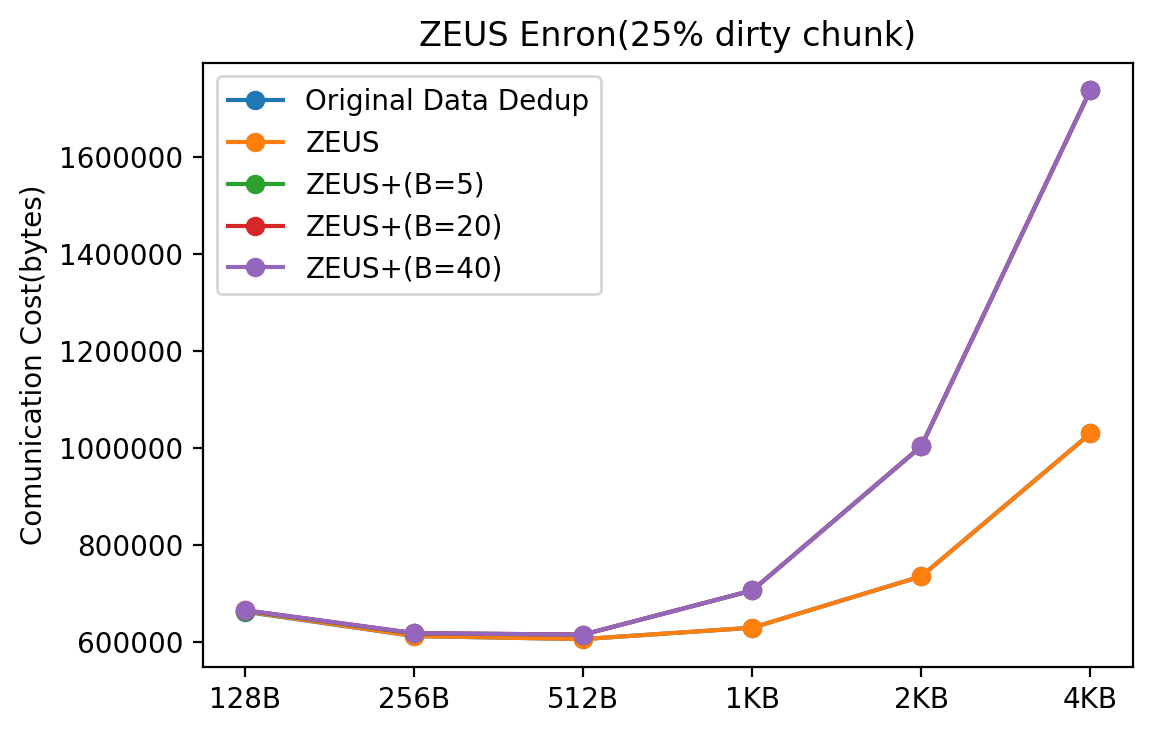

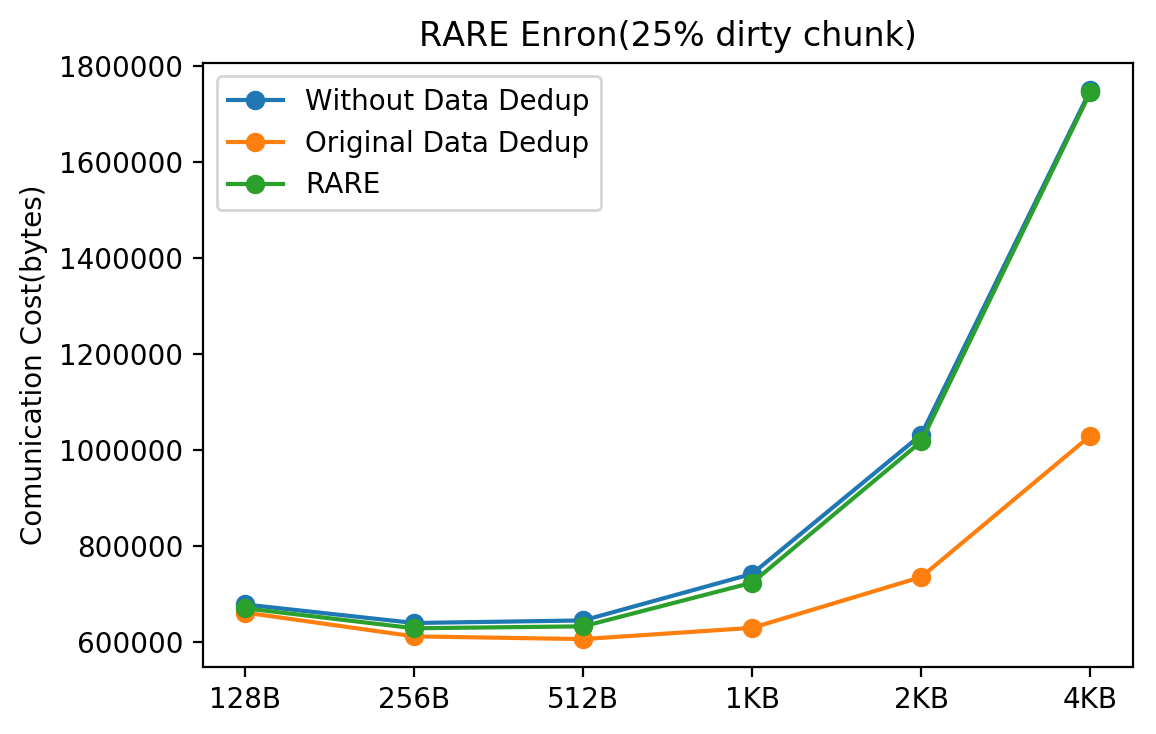

In [200]:
dirty25 = [origin_costs.copy(), zeus_costs.copy(), zeus5_costs.copy(), zeus20_costs.copy(), zeus40_costs.copy()]
dirty25_rare = [no_dedup_costs.copy(), origin_dedup_costs.copy(), rare_costs.copy()]

print("Origin Data Dedup:", origin_costs)
print("ZEUS:             ", zeus_costs)
print("ZEUS+(B=5):       ", zeus5_costs)
print("ZEUS+(B=20):      ", zeus20_costs)
print("ZEUS+(B=40):      ", zeus40_costs)
print('-------------')
print("Without Data Dedup:", no_dedup_costs)
print("Rare:              ", rare_costs)
print("Origin Data Dedup: ", origin_dedup_costs)

plt.figure(dpi = 200)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('ZEUS Enron(25% dirty chunk)')
plt.show()

plt.figure(dpi = 200)
plt.plot(x, no_dedup_costs, '-o', label = 'Without Data Dedup')
plt.plot(x, origin_dedup_costs, '-o', label = 'Original Data Dedup')
plt.plot(x, rare_costs, '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('RARE Enron(25% dirty chunk)')
plt.show()

no dirty chunk					 10% dirty chunk				 25% dirty chunk
ZEUS
['128B', '256B', '512B', '1KB', '2KB', '4KB']
[660544, 610880, 605184, 628672, 734720, 1029376] [660672, 611392, 605184, 628672, 734720, 1029376] [661696, 611392, 605184, 628672, 734720, 1029376]
[661824, 611136, 605184, 628672, 734720, 1029376] [661952, 611648, 605184, 628672, 734720, 1029376] [662720, 611648, 605184, 628672, 734720, 1029376]
[664256, 617280, 614400, 705472, 1007104, 1733888] [663872, 616768, 615424, 704448, 1000960, 1733888] [664000, 616768, 614400, 705472, 1003008, 1737984]
[664640, 617280, 613888, 705472, 1007104, 1733888] [664512, 617536, 615936, 704448, 1000960, 1733888] [664640, 617536, 614400, 705472, 1003008, 1737984]
[664768, 616768, 614912, 705472, 1007104, 1733888] [664512, 617792, 615936, 704448, 1000960, 1733888] [664768, 617536, 614400, 705472, 1003008, 1737984]
--------------
RARE
[677440, 638784, 644096, 741312, 1031680, 1750272] [677440, 638784, 644096, 741312, 1031680, 1750272] [677440, 638

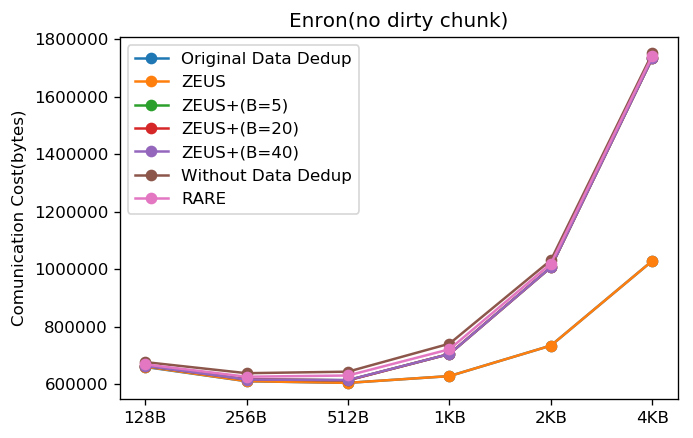

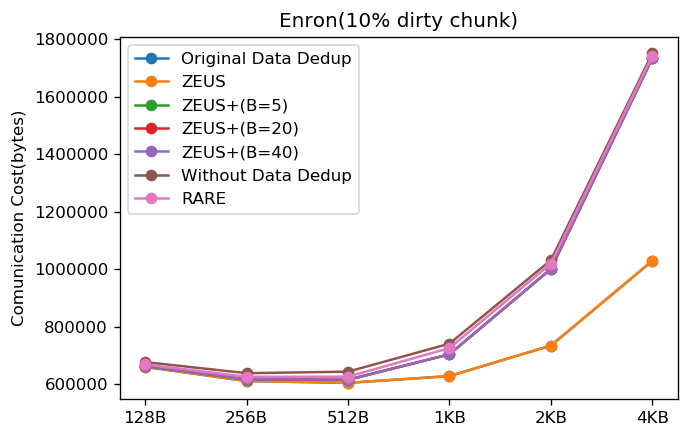

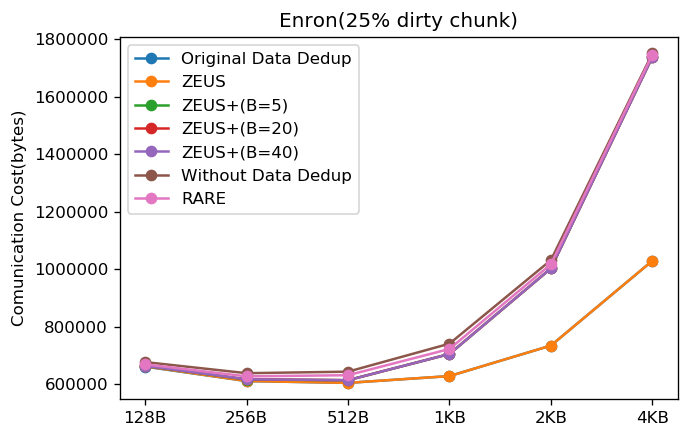

In [201]:
print('no dirty chunk\t\t\t\t\t', '10% dirty chunk\t\t\t\t', '25% dirty chunk')
print('ZEUS')
print(x)
for i in range(len(no_dirty)):
    print(no_dirty[i], dirty10[i], dirty25[i])
print('--------------')
print('RARE')
for i in range(len(no_dirty_rare)):
    print(no_dirty_rare[i], dirty10_rare[i], dirty25_rare[i])

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(no dirty chunk)')
plt.show()
    
plt.figure(dpi = 120)
plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(10% dirty chunk)')
plt.show()

plt.figure(dpi = 120)
x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
plt.legend()
plt.ylabel('Comunication Cost(bytes)')
plt.title('Enron(25% dirty chunk)')
plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, no_dirty[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty[1],  '-o', label = 'ZEUS')
# plt.plot(x, no_dirty[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, no_dirty[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, no_dirty[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(no dirty chunk)')
# plt.show()

# plt.subplot(132)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10[0],  '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10[1],  '-o', label = 'ZEUS')
# plt.plot(x, dirty10[2],  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, dirty10[3],  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, dirty10[4],  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(133)
# plt.figure(dpi = 120)
# x = ['128B', '256B', '512B', '1KB', '2KB', '4KB']
# plt.plot(x, origin_costs,  '-o', label = 'Original Data Dedup')
# plt.plot(x, zeus_costs,  '-o', label = 'ZEUS')
# plt.plot(x, zeus5_costs,  '-o', label = 'ZEUS+(B=5)')
# plt.plot(x, zeus20_costs,  '-o', label = 'ZEUS+(B=20)')
# plt.plot(x, zeus40_costs,  '-o', label = 'ZEUS+(B=40)')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('ZEUS Enron(25% dirty chunk)')
# plt.show()

# plt.subplot(131)
# plt.figure(dpi = 120)
# plt.plot(x, no_dirty_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, no_dirty_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, no_dirty_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(no dirty chunk)')
# plt.show()

# plt.subplot(232)
# plt.figure(dpi = 120)
# plt.plot(x, dirty10_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty10_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty10_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RAER Enron(10% dirty chunk)')
# plt.show()

# plt.subplot(233)
# plt.figure(dpi = 120)
# plt.plot(x, dirty25_rare[0], '-o', label = 'Without Data Dedup')
# plt.plot(x, dirty25_rare[1], '-o', label = 'Original Data Dedup')
# plt.plot(x, dirty25_rare[2], '-o', label = 'RARE')
# plt.legend()
# plt.ylabel('Comunication Cost(bytes)')
# plt.title('RARE Enron(25% dirty chunk)')
# plt.show()